In [2]:
!pip install farasapy

In [30]:
import pandas as pd
import numpy as np
from time import process_time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from custom_functions import *
# from custom_models import *

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Embedding, Dense, GlobalMaxPooling1D, MaxPooling1D, Conv1D, Dropout, GlobalAveragePooling1D,LSTM, Bidirectional, TimeDistributed, Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# For windows users (If exception in plot_model() function)
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

# Data prep

1. Load dataset

In [6]:
data = read_data("feature_engineered_data.csv")
print(data.shape)

(12537, 15)


2. Preprocess and extract features

3.  Split into train and test

In [7]:
D_train, D_val =  train_test_split(data ,test_size=0.2, random_state=42)
D_train = D_train.reset_index()
D_val = D_val.reset_index()

4. Encode target variables (labels) to integers

In [8]:
class_label = "sentiment"

y_train, y_val = D_train[class_label].values.tolist(), D_val[class_label].values.tolist()

y_train = get_label_encoding(y_train)
y_val = get_label_encoding(y_val)

print(y_train.shape, y_val.shape)

Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
Mapping:
{'NEG': 0, 'NEU': 1, 'POS': 2}
(10029, 1) (2508, 1)


# Load Word Embeddings (Input 1)

1. Tokenize Tweets

In [9]:
text_label = "tweet_preprocessed"

# Tokenize Tweets
x_train = D_train[text_label].values.tolist()
x_val = D_val[text_label].values.tolist()

tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(data['tweet_preprocessed'].values.tolist(),
                                                               x_train, x_val)

print('x_train_tokenized:',len(x_train_tokenized),'\nx_val_tokenized:',len(x_val_tokenized),
      "\nTotal Vocab: ",len(tokenizer.word_counts))

x_train_tokenized: 10029 
x_val_tokenized: 2508 
Total Vocab:  48543


2. Pad tweets

In [10]:
# Pad Tweets
maximum_text_length = 50
padding_type = "post"
truncating_type = "post"

x_train_padded = pad_text_sequence(x_train_tokenized, maximum_text_length, padding_type, truncating_type)
x_val_padded = pad_text_sequence(x_val_tokenized, maximum_text_length, padding_type, truncating_type)

print('x_train_padded:',x_train_padded.shape,'\nx_val_padded',x_val_padded.shape)

x_train_padded: (10029, 50) 
x_val_padded (2508, 50)


3. Generate embedding matrix

In [11]:
# Load word embeddings from file
vocab = tokenizer.word_index
embedding_dimension = 300
embedding_dict_file = "/content/gdrive/My Drive/Shared Tasks/Arabic Sentiment Identification/Word Embeddings/mazajak_pretrained_300.pkl"

embedding_matrix = get_embedding_matrix(vocab, embedding_dict_file = embedding_dict_file, embedding_dimension = embedding_dimension)

# Validate embedding_matrix shape
print("\nTotal Vocab:",len(vocab), "\nEmbeddings:",embedding_matrix.shape[0] -1 )

Loading embeddings from:  /content/gdrive/My Drive/Shared Tasks/Arabic Sentiment Identification/Word Embeddings/mazajak_pretrained_300.pkl

Total words processed: 42747
Words not found:  5798

Total Vocab: 48544 
Embeddings: 48544


# Load Sentiment Features (Input 2)

In [48]:
def get_sentiment_matrix(df):
    sentiment_matrix  = np.zeros((len(df), 6), dtype='float64')
    
    for i in range(len(df)):
        try:
            sentiment_matrix[i] = np.array([df['NEU_WEIGHTS'][i],df['POSNEG_WEIGHTS'][i], df['SEN_SCORE'][i], df['Pos_P'][i],
                                            df['Neg_P'][i], df['Neu_P'][i]], dtype='float64')
        except Exception as e:
            print(e)
    return sentiment_matrix

In [49]:
sentiment_train = get_sentiment_matrix(D_train)
sentiment_val = get_sentiment_matrix(D_val)

print("Sentiment matrix (Train): {}\nSentiment matrix (Test): {}".format(sentiment_train.shape, sentiment_val.shape))

Sentiment matrix (Train): (10029, 6)
Sentiment matrix (Test): (2508, 6)


# Simple FFNN

In [ ]:
i1 = Input(shape = (sentiment_train.shape[1]))
d1 = Dense(64, activation = "relu")(i1)
d2 = Dense(32, activation = "relu")(d1)
d3 = Dense(3, activation = "softmax")(d2)

model = Model(inputs = i1, outputs= d3)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

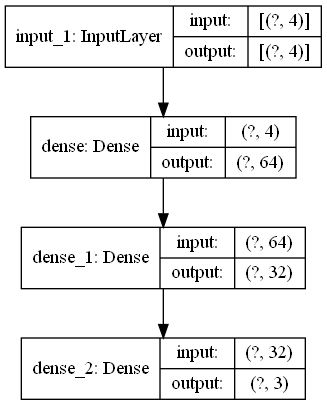

In [ ]:
# m.summary()
plot_model(model, show_shapes=True)

In [ ]:
h = model.fit(sentiment_train, y_train, epochs=10, validation_data = (sentiment_val, y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 3s 330us/sample - loss: 0.2961 - acc: 0.8881 - val_loss: 0.2003 - val_acc: 0.9254
Epoch 2/10
10029/10029 [==============================] - 1s 110us/sample - loss: 0.2221 - acc: 0.9173 - val_loss: 0.1967 - val_acc: 0.9278
Epoch 3/10
10029/10029 [==============================] - 1s 102us/sample - loss: 0.2193 - acc: 0.9172 - val_loss: 0.1965 - val_acc: 0.9254
Epoch 4/10
10029/10029 [==============================] - 1s 87us/sample - loss: 0.2152 - acc: 0.9199 - val_loss: 0.1938 - val_acc: 0.9242
Epoch 5/10
10029/10029 [==============================] - 1s 84us/sample - loss: 0.2155 - acc: 0.9190 - val_loss: 0.1940 - val_acc: 0.9274
Epoch 6/10
10029/10029 [==============================] - 1s 98us/sample - loss: 0.2131 - acc: 0.9203 - val_loss: 0.1950 - val_acc: 0.9294
Epoch 7/10
10029/10029 [==============================] - 1s 142us/sample - loss: 0.2125 - acc: 0.9210 - val_loss:

# Multi-Channel Bi-LSTM

In [ ]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

#--------------------------------------------------------------------------------------------------------------------#

# Define model hyperparameters
input_length1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

input2 = sentiment_train
input_length2 = input2.shape[1]

output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length1,"x",embedding_dimension)
print('Shape of Input layer 1: ',len(x_train),"x",embedding_dimension)
print('Shape of Input layer 2: ',len(x_train),"x",input_length2)

print("Output classes: ",output_dimension)
#--------------------------------------------------------------------------------------------------------------------#

# Define Input Channel 1

Input_layer1 = Input(shape = (input_length1,))
Embedding_layer1 = Embedding(input_length = input_length1, input_dim = embedding_vocab1, output_dim = embedding_dimension1,
                             weights = [embedding_matrix], trainable = False)(Input_layer1)

LSTM_layer1 = Bidirectional(LSTM(128, return_sequences = True))(Embedding_layer1)
Max_Pool_1 = GlobalMaxPooling1D()(LSTM_layer1)
Dense1 = Dense(64, activation = "relu")(Max_Pool_1)
dropout_Dense1 = Dropout(0.25)(Dense1)

# Input Channel 2
Input_layer2 = Input(shape= (input_length2,))
# Dense2 = Dense(64, activation = "relu")(Input_layer2)

# Concatentate Channels
Concat_layer= concatenate([dropout_Dense1, Input_layer2])

# Define output layer
Output_layer = Dense(output_dimension, activation = "softmax")(Concat_layer)


# Compile model
model = Model(inputs = [Input_layer1, Input_layer2], outputs = Output_layer)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics= ["acc"])

Shape of each Input Sentence:  50 x 300
Shape of Input layer 1:  10029 x 300
Shape of Input layer 2:  10029 x 4
Output classes:  3


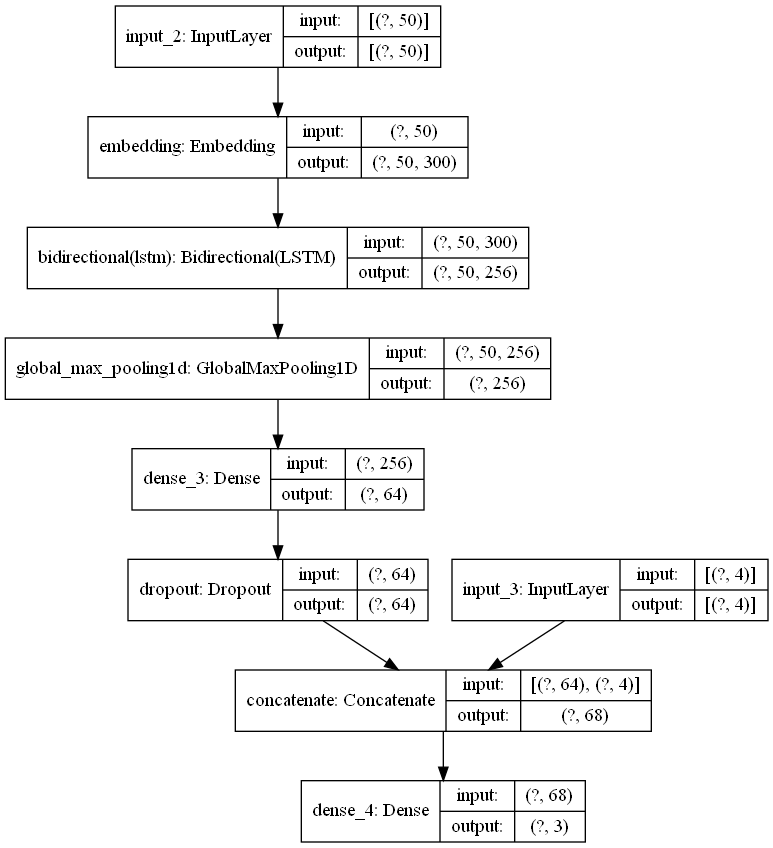

In [ ]:
# model.summary()
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train],
                         y_train, epochs=10, batch_size= 128, verbose=1, validation_data = ([x_val_padded,sentiment_val],
                                                                                            y_val))

Train on 10029 samples, validate on 2508 samples
Epoch 1/10
10029/10029 [==============================] - 78s 8ms/sample - loss: 0.8193 - acc: 0.6886 - val_loss: 0.4831 - val_acc: 0.7998
Epoch 2/10
10029/10029 [==============================] - 66s 7ms/sample - loss: 0.4357 - acc: 0.8330 - val_loss: 0.3342 - val_acc: 0.8951
Epoch 3/10
10029/10029 [==============================] - 66s 7ms/sample - loss: 0.3231 - acc: 0.8948 - val_loss: 0.2684 - val_acc: 0.9183
Epoch 4/10
10029/10029 [==============================] - 73s 7ms/sample - loss: 0.2681 - acc: 0.9203 - val_loss: 0.2564 - val_acc: 0.9167
Epoch 5/10
10029/10029 [==============================] - 75s 7ms/sample - loss: 0.2333 - acc: 0.9313 - val_loss: 0.2273 - val_acc: 0.9330
Epoch 6/10
 9984/10029 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.9404

6. Evaluate Model

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

In [ ]:
# save model

# Multi-Channel CNN

In [ ]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
gmp = GlobalMaxPooling1D()(c1)
c1_do = Dropout(0.3)(gmp)
# max_pool1 = MaxPooling1D(pool_size=3)(c1_do)


d1 = Dense(64, activation="relu")(c1_do)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
# d2 = Dense(64, activation = "relu")(i2)

# Merge Channels
merged = concatenate([d1,i2])

#output
output = Dense(output_dim, activation = "softmax")(merged)


# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs = 10, batch_size = 64,
                                  validation_data = ([x_val_padded, sentiment_val],y_val))

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# Multi-Channel CNN-BiLSTM

In [ ]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
input2 = sentiment_train
input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

#--------------------------------------------------------------------------------------------------------------------#

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
c1_do = Dropout(0.3)(c1)
max_pool1 = MaxPooling1D(pool_size=3)(c1_do)

b1 = Bidirectional(LSTM(128, dropout = 0.3, return_sequences = True, ))(max_pool1)
gmp1 = GlobalMaxPooling1D()(b1)

d1 = Dense(64, activation = "relu")(gmp1)

# Input Channel 2
i2 = Input(shape = (input_len2, ))
# d2 = Dense(64, activation = "relu")(i2)

# Merge channels
merge = concatenate([d1, i2])

# Output layer
output = Dense(output_dim, activation = "softmax")(merge)


#---------------------------------------------------------------------------------------------------------------------#

# Compile
model = Model(inputs = [i1, i2], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model_history = model.fit([x_train_padded, sentiment_train], y_train, epochs=10, verbose = 1, batch_size=64,
                         validation_data=([x_val_padded,sentiment_val], y_val))

In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded,sentiment_val]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# CNN-BiLSTM

In [15]:
# Input 1
input1 = embedding_matrix
input_len1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

# Input 2
# input2 = sentiment_train
# input_len2 = sentiment_train.shape[1]

# Output
output_dim = len(np.unique(y_train))

#--------------------------------------------------------------------------------------------------------------------#

# Input Channel 1
i1 = Input(shape = (input_len1, ))
e1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [input1], trainable = False)(i1)
c1 = Conv1D(filters = 256, kernel_size=3, padding = "same", activation="relu")(e1)
c1_do = Dropout(0.3)(c1)
max_pool1 = MaxPooling1D(pool_size=3)(c1_do)

b1 = Bidirectional(LSTM(128, dropout = 0.3, return_sequences = True, ))(max_pool1)
gmp1 = GlobalMaxPooling1D()(b1)

d1 = Dense(64, activation = "relu")(gmp1)

# Input Channel 2
# i2 = Input(shape = (input_len2, ))
# d2 = Dense(64, activation = "relu")(i2)

# Merge channels
# merge = concatenate([d1, i2])

# Output layer
output = Dense(output_dim, activation = "softmax")(d1)


#---------------------------------------------------------------------------------------------------------------------#

# Compile
model = Model(inputs = [i1], outputs = output)
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["acc"])

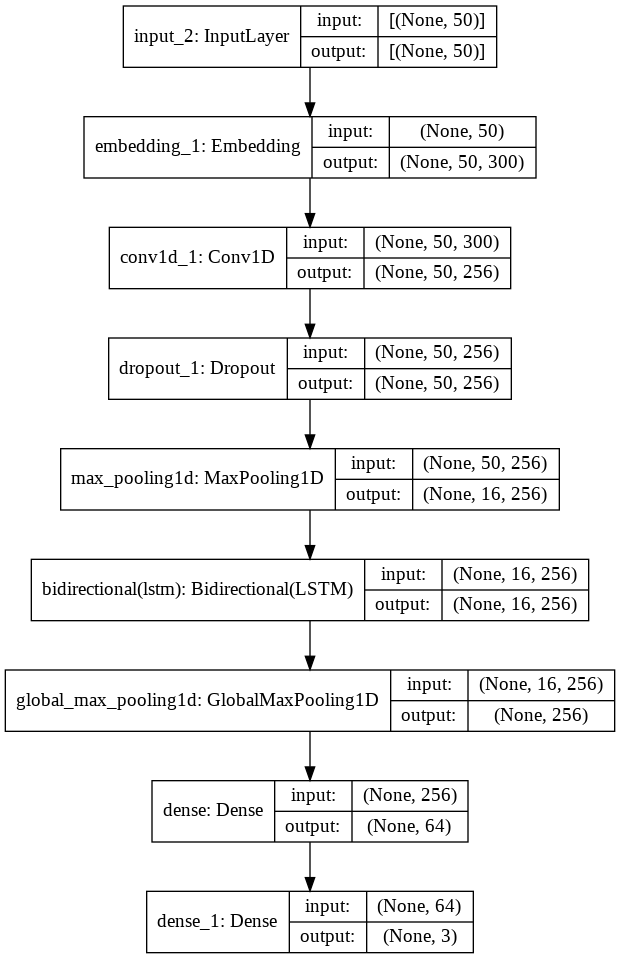

In [16]:
plot_model(model, show_shapes = True)

In [17]:
model_history = model.fit([x_train_padded], y_train, epochs=10, verbose = 1, batch_size=64,
                         validation_data=([x_val_padded], y_val))

Epoch 1/10
157/157 [==============================] - 36s 209ms/step - loss: 0.9883 - acc: 0.5173 - val_loss: 0.9042 - val_acc: 0.5849
Epoch 2/10
157/157 [==============================] - 32s 205ms/step - loss: 0.9017 - acc: 0.5905 - val_loss: 0.8676 - val_acc: 0.6073
Epoch 3/10
157/157 [==============================] - 32s 203ms/step - loss: 0.8229 - acc: 0.6338 - val_loss: 0.8306 - val_acc: 0.6224
Epoch 4/10
157/157 [==============================] - 31s 200ms/step - loss: 0.7219 - acc: 0.7010 - val_loss: 0.8885 - val_acc: 0.6176
Epoch 5/10
157/157 [==============================] - 31s 196ms/step - loss: 0.6189 - acc: 0.7497 - val_loss: 0.9246 - val_acc: 0.5841
Epoch 6/10
157/157 [==============================] - 31s 195ms/step - loss: 0.4963 - acc: 0.8036 - val_loss: 0.8746 - val_acc: 0.6304
Epoch 7/10
157/157 [==============================] - 31s 195ms/step - loss: 0.3856 - acc: 0.8547 - val_loss: 0.9740 - val_acc: 0.6368
Epoch 8/10
157/157 [==============================] - 3

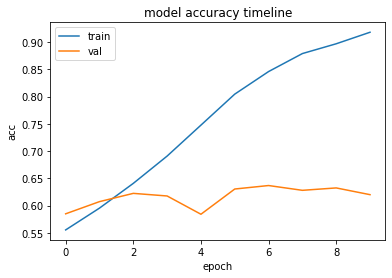

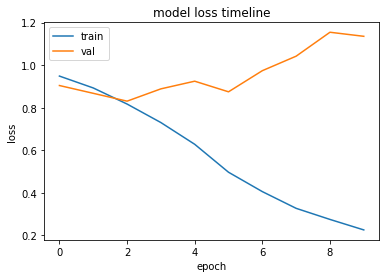


Classification Report:

               precision    recall  f1-score   support

           0       0.62      0.64      0.63       924
           1       0.71      0.66      0.69      1172
           2       0.41      0.46      0.43       412

    accuracy                           0.62      2508
   macro avg       0.58      0.59      0.58      2508
weighted avg       0.63      0.62      0.62      2508



In [20]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

# CNN - BiLSTM with Attention

In [38]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        super(AttentionLayer, self).build(attention_input)
        lstm_shape, cnn_shape = attention_input
        # Attention Weights for LSTM
        self.W_in = self.add_weight(shape=(lstm_shape[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
        
        # Attention Weights for CNN
        self.W_context = self.add_weight(shape=(cnn_shape[-1], 1),
                                         initializer='glorot_normal',
                                         trainable=True,
                                         name='context_attention_weights')
                                      
        # Attention Bias
        self.b = self.add_weight(shape=(lstm_shape[1], 1),
                                 initializer='glorot_normal',
                                 trainable=True,
                                 name='attention_bias')
        
        
        
    def call(self, attention_input):
        lstm_output, cnn_output = attention_input
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) + 
                              K.dot(cnn_output, self.W_context) +
                              self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = at * lstm_output
        attention_output = K.sum(attention_output, axis=1)
        return attention_output
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [53]:
# Define callback
# custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

#--------------------------------------------------------------------------------------------------------------------#

# Define model hyperparameters
input_length1 = maximum_text_length
embedding_vocab1 = embedding_matrix.shape[0]
embedding_dimension1 = embedding_matrix.shape[1]

input2 = sentiment_train
input_length2 = input2.shape[1]

output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length1,"x",embedding_dimension)
print('Shape of Input layer 1: ',len(x_train),"x",embedding_dimension)
print('Shape of Input layer 2: ',len(x_train),"x",input_length2)

print("Output classes: ",output_dimension)
#--------------------------------------------------------------------------------------------------------------------#

Shape of each Input Sentence:  50 x 300
Shape of Input layer 1:  10029 x 300
Shape of Input layer 2:  10029 x 6
Output classes:  3


In [66]:
Input1 = Input(shape=(input_len1,))
Embedding_layer1 = Embedding(input_length=input_len1, input_dim=embedding_vocab1, output_dim = embedding_dimension1,
               weights = [embedding_matrix], trainable = False)(Input1)

# Input 1(BiLSTM):
Lstm = Bidirectional(LSTM(128, dropout=0.3, return_sequences=True))(Embedding_layer1)

# Input 2 (CNN):
Conv1 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(Embedding_layer1)
Dropout1 = Dropout(0.3)(Conv1)
# Conv2 = Conv1D(filters=256, kernel_size=4, activation='relu', padding='same')(Embedding_layer1)
# Dropout2 = Dropout(0.3)(Conv2)
# Conv3 = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(Embedding_layer1)
# Dropout3 = Dropout(0.3)(Conv3)
# merged = concatenate([Dropout1, Dropout2, Dropout3], axis=1)
# max_pool = MaxPooling1D(pool_size=3)(merged)


attention = AttentionLayer()([Lstm, Dropout1])
Dense1 = Dense(64, activation='relu')(attention)
Dropout_dense = Dropout(0.25)(Dense1)
outputs = Dense(4, activation='softmax')(Dropout_dense)

model = Model(inputs=Input1, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 50, 300)      14563500    input_23[0][0]                   
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 50, 256)      230656      embedding_19[0][0]               
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 50, 256)      439296      embedding_19[0][0]               
____________________________________________________________________________________________

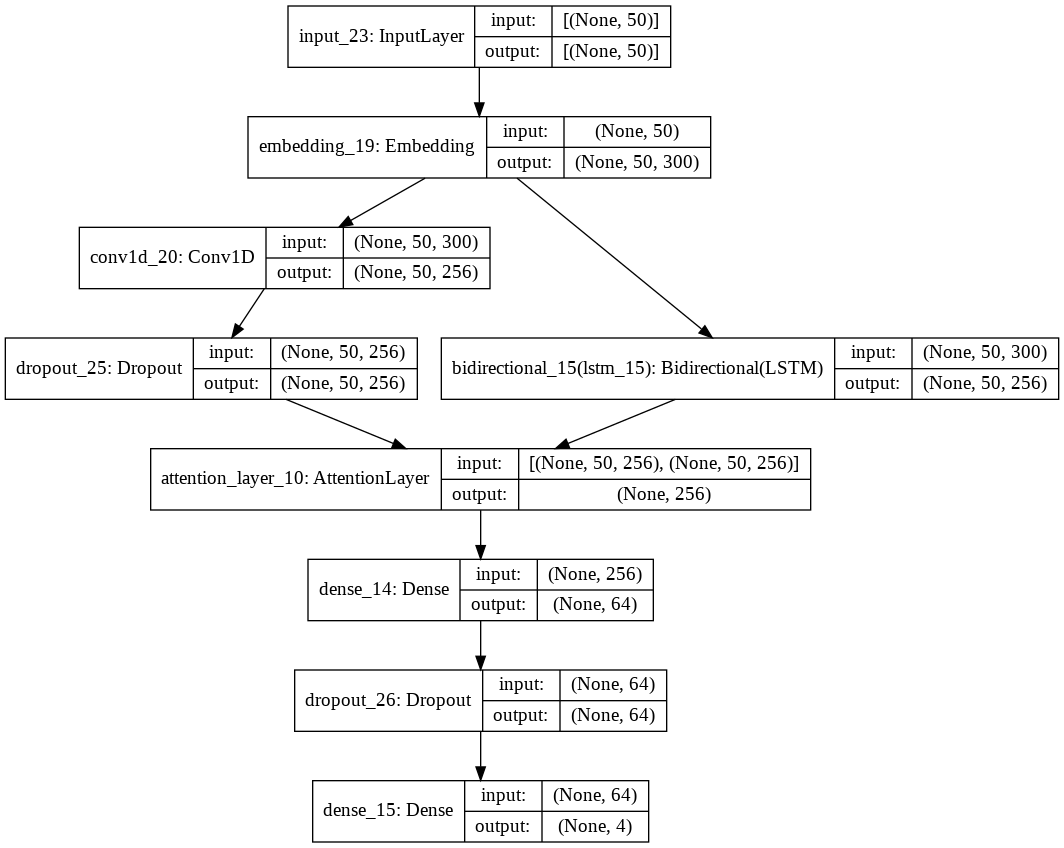

In [67]:
plot_model(model, show_shapes = True)

In [68]:
model_history = model.fit([x_train_padded], y_train, epochs=10, verbose = 1, batch_size=64,
                         validation_data=([x_val_padded], y_val))

Epoch 1/10
157/157 [==============================] - 61s 369ms/step - loss: 1.0659 - acc: 0.4921 - val_loss: 0.8978 - val_acc: 0.5865
Epoch 2/10
157/157 [==============================] - 57s 362ms/step - loss: 0.9167 - acc: 0.5888 - val_loss: 0.8846 - val_acc: 0.5953
Epoch 3/10
157/157 [==============================] - 57s 361ms/step - loss: 0.9006 - acc: 0.5879 - val_loss: 0.8882 - val_acc: 0.5961
Epoch 4/10
157/157 [==============================] - 57s 362ms/step - loss: 0.8754 - acc: 0.6067 - val_loss: 0.8564 - val_acc: 0.6057
Epoch 5/10
157/157 [==============================] - 57s 361ms/step - loss: 0.8551 - acc: 0.6223 - val_loss: 0.8439 - val_acc: 0.6212
Epoch 6/10
157/157 [==============================] - 57s 364ms/step - loss: 0.8242 - acc: 0.6393 - val_loss: 0.8336 - val_acc: 0.6240
Epoch 7/10
157/157 [==============================] - 57s 364ms/step - loss: 0.8028 - acc: 0.6462 - val_loss: 0.8449 - val_acc: 0.6200
Epoch 8/10
157/157 [==============================] - 5

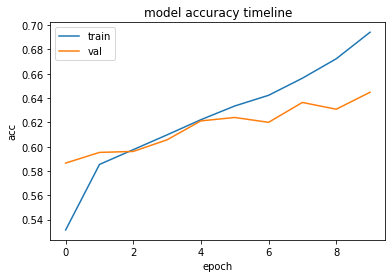

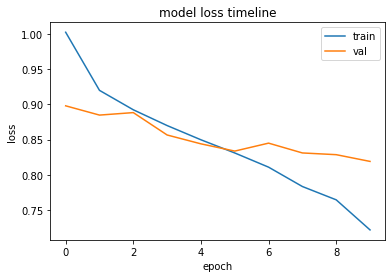


Classification Report:

               precision    recall  f1-score   support

           0       0.60      0.77      0.67       924
           1       0.72      0.65      0.68      1172
           2       0.55      0.34      0.42       412

    accuracy                           0.64      2508
   macro avg       0.62      0.59      0.59      2508
weighted avg       0.65      0.64      0.64      2508



In [69]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(model.predict([x_val_padded]),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))